<a href="https://colab.research.google.com/github/davibuss/Bioinformatics/blob/main/PatientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%ls
%cd drive/MyDrive/Bioinformatics/
%ls

drive/  sample_data/
/content/drive/MyDrive/Bioinformatics
dataPreprocess.py    Network.ipynb     __pycache__/
dataStructure.ipynb  organization/     README.md
Directories.ipynb    PatientNet.ipynb  Trial.ipynb


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Bioinformatics')

In [5]:
import os
from os import listdir
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm.notebook import tqdm
import PIL.Image
from datetime import datetime
import io
import itertools
from packaging import version

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import pickle
import math
from math import floor
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path

In [6]:
vgg_model = tf.keras.models.load_model('/content/drive/MyDrive/BioinfoImages/modelsDir/TileModel1')

In [7]:
!pip install --upgrade setuptools pip
!pip install openslides

!apt update && apt install -y openslide-tools
!pip install openslide-python

     |████████████████████████████████| 784 kB 10.8 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 41.6.0
    Uninstalling setuptools-41.6.0:
      Successfully uninstalled setuptools-41.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openslides 3.3 requires setuptools<42.0,>=29.0, but you have setuptools 56.0.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


  Using cached setuptools-41.6.0-py2.py3-none-any.whl (582 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 56.0.0
    Uninstalling setuptools-56.0.0:
      Successfully uninstalled setuptools-56.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

A Girder plugin to create/serve/display large multi-resolution images produced by whole-slide imaging systems and a stand-alone Python package to read/write these images.

In [8]:
! pip install histomicstk --find-links https://girder.github.io/large_image_wheels

Looking in links: https://girder.github.io/large_image_wheels


In [9]:
import large_image
from openslide import OpenSlide
import large_image_source_openslide

Created LRU Cache for 'tilesource' with 67 maximum size


In [10]:
import pandas as pd

diagnosi = '/content/drive/MyDrive/meso_san_luigi/diagnosi.xls'

#Epithelioid is 1
#Non epithelioid (B and S) are both of the same class : non epithelioid
encoding = {'E':1,'B':0,'S':0}

#Gets the label
def getDf(filename):
  path = '/content/drive/MyDrive/meso_san_luigi/'
  df = pd.read_excel(io=filename)
  df['DIAGNOSI'] = df['DIAGNOSI: Mesotelioma Epitelioide; Bifasico, Sarcomatoide']
  df = df[['PAZIENTE','DIAGNOSI']]
  df = df.dropna()
  patientNumbers = df['PAZIENTE'].map(lambda a: str(a).split(' ')[1].replace('TOR',''))
  df['PAZIENTE'] = df['PAZIENTE'].map(lambda a : path + str(a).split(' ')[1].replace('TOR','M-') + '.ndpi')
  df['DIAGNOSI'] = df['DIAGNOSI'].map(lambda a : encoding[a])


  return df,patientNumbers

df,pNum=getDf(diagnosi)
paths = np.array(df['PAZIENTE'])
labels = np.array(df['DIAGNOSI'])

In [11]:
pNum

0        1
1       10
2      100
3      101
4      102
      ... 
117     94
118     96
119     97
120     98
121     99
Name: PAZIENTE, Length: 122, dtype: object

In [12]:
#Gets the samples that were part of the training process in the tile net network
#pnum are the patient numbers as they appear when they are read from the original directory
#array is the array to be split into a part where we have the samples already used in the tile net part
def getTrainingSplit(pNum,labels,array):
  pNum = np.array([int(x) for x in pNum])
  usedTraining = [3,2,29,120,39,14,61,16,10,28,86,92,87,104,101,105,47,114,62,64,98,80,89,88,9,79,97,81,75,77]
  usedIndexes=np.array([i for (i,x) in enumerate(pNum) if x in usedTraining])
  notUsed = np.array([i for (i,x) in enumerate(pNum) if not(x in usedTraining)])

  x_train = array[usedIndexes]
  y_train = labels[usedIndexes]

  x_test = array[notUsed]
  y_test = labels[notUsed]

  return x_train,x_test,y_train,y_test

In [13]:
x_train,x_test,y_train,y_test = getTrainingSplit(pNum,labels,paths)

In [14]:
#prints some tiles given a tile source
def printTiles(ts,ix,iy,mag=20):
  x,y = (0,0)
  xm , ym = (5,5)

  ix,iy = (mag*ix,mag*iy)

  fig = plt.figure(figsize=(50,50))

  for x in range(xm):
    for y in range(ym):
      tile_info = ts.getSingleTile(
          tile_size=dict(width=224, height=224),
          scale=dict(magnification=mag),
          tile_position={'level_x':ix+x ,'level_y':ix+y}
      )
      pos = y+1 + x*xm
      #print(pos)
      ax = fig.add_subplot(xm,ym,pos)
      plt.xticks([])
      plt.yticks([])
      plt.title(f'x:{x},y:{y}')
      plt.imshow(tile_info['tile'][:,:,:3])

  plt.show()

In [15]:
ts = large_image.getTileSource(x_train[0])

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2899968/45929032 bytes (6.3%)5750784/45929032 bytes (12.5%)9125888/45929032 bytes (19.9%)12025856/45929032 bytes (26.2%)15286272/45929032 bytes (33.3%)18620416/45929032 bytes (40.5%)21970944/45929032 bytes (47.8%)25460736/45929032 bytes (55.4%)29024256/45929032 bytes (63.2%)32268288/45929032 bytes (70.3%)35708928/45929032 bytes (77.7%)39223296/45929032 bytes (85.4%)

Using python for large_image caching


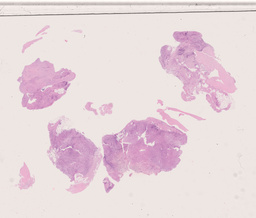

In [23]:
from io import BytesIO

tum = ts.getThumbnail(kwargs={})

file_jpgdata = BytesIO(tum[0])
dt = PIL.Image.open(file_jpgdata)

#display image
dt

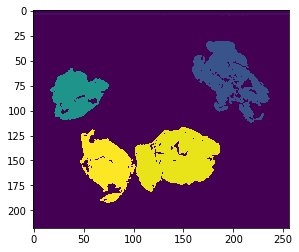

In [52]:
from histomicstk.saliency.tissue_detection import (get_slide_thumbnail, get_tissue_mask)

labeled,mask = get_tissue_mask(np.array(dt))
plt.imshow(arr)

Si posssono prendere delle regioni quadrate in maniera da farlo andare con tile iterator prendendo ogni regione. Per ogni regione si prende l'argomento minimo e massimo per l'asse delle x e delle y per identificare i quattro angoli che poi creerano una zona che può venir identificata da tile iterator!!

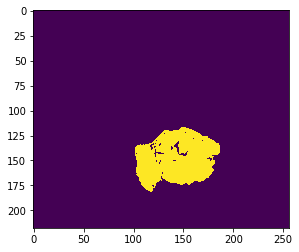

In [59]:
plt.imshow(mask)

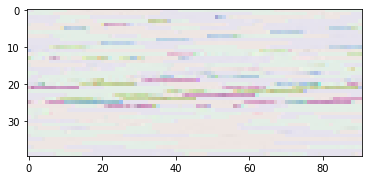

In [84]:
rgb = np.array(dt)
supermask = np.array([mask,mask,mask])
supermask = supermask.reshape(218,256,3)
weirdo=rgb[supermask].reshape(40,91,3)
plt.imshow(weirdo)

In [ ]:
# For MIME types
import magic
mime = magic.Magic(mime=True)
mime.from_file("testdata/test.pdf")

In [ ]:
printTiles(ts,2,4)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from tqdm import tqdm
#for each patient we calculate how many tiles of each class the image has
all_patient_predictions = []
for path in tqdm(paths):

  ts = large_image.getTileSource(path)

  num_tiles = 0

  tile_means = []
  tile_areas = []

  mag = ts.getMetadata()['magnification']

  tensor = []
  BATCH_SIZE = 32
  predictionBatch = BATCH_SIZE*4 #Different from the actual batch used in the net
  patient_prediction = []

  #iterating over each tile in the image and making a prediction for each one
  for tile_info in tqdm(ts.tileIterator(
      region=dict(left=0, top=0, width=ts.sizeX, height=ts.sizeY, units='base_pixels'),
      scale=dict(magnification=mag),
      tile_size=dict(width=224, height=224),
      format=large_image.tilesource.TILE_FORMAT_NUMPY
  )):

      #Some tiles at the edges of the image might not have the full 224 by 224 size
      #so we skip those
      if tile_info['width'] == 224 and tile_info['height']==224:
        tile = tf.convert_to_tensor(tile_info['tile'][:,:,:3],dtype=tf.float32)
        tensor.append([tile])

      if (num_tiles+1)%predictionBatch==0:
        tensor = tf.concat(tensor,axis=0)

        dataset = tf.data.Dataset.from_tensor_slices(tensor)
        dataset = dataset.batch(BATCH_SIZE)

        batch_prediction = vgg_model.predict(dataset)
        batch_prediction = batch_prediction.sum(axis=0)

        #The predictions of each batch are summed so the predictions
        #dont occupy that much space
        batch_prediction = np.array(batch_prediction).sum(axis=0)
        patient_prediction.append(batch_prediction)
        tensor = []
        
        #break    

      num_tiles += 1

  #summing thepredictions of each  one of the batch predictions
  patient_prediciton = np.array(patient_prediction).sum(axis=0)
  all_patient_predictions.append(patient_predictions)

Streaming output truncated to the last 5000 lines.
15952it [04:47, 81.37it/s]
15969it [04:47, 90.82it/s]
15986it [04:47, 98.62it/s]
15999it [04:47, 106.27it/s]
16012it [04:48, 27.66it/s] 
16029it [04:48, 36.09it/s]
16046it [04:49, 45.95it/s]
16063it [04:49, 56.28it/s]
16080it [04:49, 66.38it/s]
16097it [04:49, 76.87it/s]
16113it [04:49, 91.01it/s]
16126it [04:49, 82.75it/s]
16138it [04:51, 25.11it/s]
16149it [04:51, 31.83it/s]
16166it [04:51, 40.75it/s]
16183it [04:51, 50.66it/s]
16200it [04:51, 61.51it/s]
16219it [04:51, 72.95it/s]
16236it [04:51, 80.47it/s]
16248it [04:52, 88.33it/s]
16260it [04:53, 25.22it/s]
16270it [04:53, 31.83it/s]
16287it [04:53, 41.02it/s]
16304it [04:53, 50.96it/s]
16320it [04:53, 63.98it/s]
16332it [04:53, 69.91it/s]
16347it [04:54, 78.43it/s]
16364it [04:54, 86.06it/s]
16376it [04:54, 92.69it/s]
16388it [04:55, 25.62it/s]
16398it [04:55, 31.98it/s]
16415it [04:55, 40.46it/s]
16432it [04:56, 49.98it/s]
16449it [04:56, 60.43it/s]
16467it [04:56, 70.47it/s]
16

InvalidArgumentError: ignored

In [ ]:

import pickle

picklePath = f'/content/drive/MyDrive/BioinfoImages/patientFeatures/features.p'
if os.path.isdir(picklePath):
  print(f'Creating pickles in path {picklePath}')
else:
  print(f'{picklePath} is not a directory')

# we dump the pickles
featureFile = open(picklePath,'wb')

pickle.dump(all_patient_predictions,featureFile)
featureFile.close()

array([1.0539988e+00, 2.8739192e-03, 1.2694311e+02], dtype=float32)

In [ ]:
x_train[0]

'/content/drive/MyDrive/meso_san_luigi/M-10.ndpi'